In [1]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import math

!pip install --upgrade keras tensorflow-gpu
!pip install tqdm

from tqdm import tqdm
import pandas as pd
import json
from shutil import copyfile, rmtree
from tensorflow.python.ops import array_ops, math_ops


import keras
import keras.backend as K
import tensorflow as tf
from keras.applications import *

from keras.layers import Conv2D, Dense, Flatten, Input, Lambda, MaxPooling2D, Input, GlobalMaxPooling2D, Dropout
from keras.models import Model
import sys

import random
!pip install imgaug
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
from metric_learning import triplet_semihard_loss

import skimage
from distutils.version import LooseVersion

from datetime import datetime


tqdm.pandas()
DATA_SRC_DIR = '/home/jovyan/data/humpback/train/'
DATA_PREPROCESSED = 'data'


Requirement already up-to-date: keras in /home/gj/miniconda3/lib/python3.6/site-packages (2.2.4)
Requirement already up-to-date: tensorflow-gpu in /home/gj/miniconda3/lib/python3.6/site-packages (1.12.0)


/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


## Sanity Check

In [2]:
!nvidia-smi

Thu Jan 17 23:14:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| 29%   42C    P8    10W / 185W |    488MiB /  7949MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
df = pd.read_csv('tail_keypoints_new.csv')
keypoints = dict()
for i, row in df.iterrows():
    keypoints[row['image']] = [int(row['left_x']), int(row['left_y']), int(row['mid_x']), int(row['mid_y']), int(row['right_x']), int(row['right_y'])]

In [4]:
df = pd.read_csv('bounding_boxes.csv')
bboxes = dict()
for i, row in df.iterrows():
    bboxes[row['Image']] = [int(row['y0']), int(row['y1']), int(row['x0']), int(row['x1'])]

In [5]:
import tensorflow as tf



def tf_print(op, tensors, message=None):
    def print_message(x):
        sys.stdout.write(message + " %s\n" % x)
        return x

    prints = [tf.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    with tf.control_dependencies(prints):
        op = tf.identity(op)
    return op

def _pairwise_distances(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
    feature: 2-D Tensor of size [number of data, feature dimension].
    squared: Boolean, whether or not to square the pairwise distances.
    Returns:
    pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    
    pairwise_distances_squared = math_ops.add(
      math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
      math_ops.reduce_sum(
          math_ops.square(array_ops.transpose(feature)),
          axis=[0],
          keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                  array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
             pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
      pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
      array_ops.ones([num_data]))
    
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    
    return pairwise_distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(labels, tf.transpose(labels))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(labels, tf.transpose(labels))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    #pairwise_dist = tf_print(pairwise_dist, [pairwise_dist], '\n pairwise: ')


    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = 1e-3*anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss


def batch_hard_triplet_loss(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    #hardest_positive_dist = tf_print(hardest_positive_dist, [hardest_positive_dist], '\n pos embedding: ')
    
    
    
    
    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    #hardest_negative_dist = tf_print(hardest_negative_dist, [hardest_negative_dist], '\n neg embedding: ')

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    #triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)
    triplet_loss = tf.maximum(1e-1*hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

def hardest_negative_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)
    
    maximum = math_ops.reduce_max(pairwise_dist, keepdims=True)
    result = math_ops.reduce_min(
        math_ops.multiply(pairwise_dist - maximum, mask_anchor_negative),
        keepdims=True) + maximum
    
    return result

def mean_negative_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    anchor_negative_dist = tf.multiply(pairwise_dist, mask_anchor_negative)
    
    return tf.reduce_sum(anchor_negative_dist)/tf.reduce_sum(mask_anchor_negative)

def num_neg_pairs(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """


    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    
    return tf.reduce_sum(mask_anchor_negative)

def hardest_positive_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    anchor_positive_dist = tf.multiply(pairwise_dist, mask_anchor_positive)
    
    return tf.reduce_max(anchor_positive_dist)

def mean_positive_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    anchor_positive_dist = tf.multiply(pairwise_dist, mask_anchor_positive)
    
    return tf.reduce_sum(anchor_positive_dist)/tf.reduce_sum(mask_anchor_positive)

def num_pos_pairs(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    return tf.reduce_sum(mask_anchor_positive)

In [6]:
def flatten_tail(im, lx, ly, mx, my, rx, ry, target_size=(512, 512)):    
    M = cv2.getAffineTransform(
        np.array([(lx, ly), (mx, my), (rx, ry)]).astype(np.float32),
        np.array([(20, 20), ((target_size[1] - 1)//2, (target_size[0] - 1)//2), ((target_size[1] - 1) - 20, 20)]).astype(np.float32),
    )
    dst = cv2.warpAffine(im, M, target_size[::-1])
    
    return dst

def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().
    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)


def preprocess(inp):
    return inp.astype(np.float)/255

def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square", random_pad = False):
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)


    # Get new height and width
    h, w = image.shape[:2]

    if random_pad:
        top_pad = np.random.randint(max_dim - h + 1)
        left_pad = np.random.randint(max_dim - w + 1)
    else:
        top_pad = (max_dim - h) // 2
        left_pad = (max_dim - w) // 2

    bottom_pad = max_dim - h - top_pad        
    right_pad = max_dim - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)
    window = (top_pad, left_pad, h + top_pad, w + left_pad)
    
    return image.astype(image_dtype)


def read_image(path, target_size):
    h, w = target_size
    img = cv2.imread(path)
    img = cv2.resize(img, (w, h))

    img = img.astype(np.float32)/255
    #img = img[ ... , :1]
    return img
    

class Generator(object):
    """
        A generator to select 3 images (anchor, positive, negative) to be trained using triplet loss embedding
    """
    def __init__(self, cls, dim, bboxes, keypoints, aug = None,
                    batch_size=32, embedding_size = 256, num_channels = 3):
        
        
        self.dim = dim
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.bboxes = bboxes
        self.keypoints = keypoints
        
        
        self.cls = cls
        self.num_cls = len(cls)
        
        self.num_channels = 3
        self.augmenter = aug



    def next(self):
                #(anchor, positive, negative) = self.select_tripple()
            
        batch_images = np.zeros(shape=(self.batch_size, self.dim, self.dim, self.num_channels),dtype=np.uint8)
        batch_annotations = np.zeros(shape=(self.batch_size,),dtype=np.float32)
        
        options = []
        picked_cls = None
        chosen_file = None
        
        while len(options) < 2:
            picked_cls = np.random.randint(self.num_cls)
            options = glob(os.path.join(self.cls[picked_cls], '*'))
            chosen_file = np.random.choice(options)
            
        batch_images[0] = self.read(chosen_file)
        batch_annotations[0] = picked_cls
        if np.random.rand() > 0.2:
            options.remove(chosen_file)
                
        chosen_file = np.random.choice(options)
        batch_images[1] = self.read(chosen_file)
        batch_annotations[1] = picked_cls
            

        for b in range(2,self.batch_size):
            
            if np.random.rand() > 0.1 and len(options) > 0 and b < self.batch_size-1:
                
                chosen_file = np.random.choice(options)
                    
            else:
                picked_cls = np.random.randint(self.num_cls)
                options = glob(os.path.join(self.cls[picked_cls], '*'))
                chosen_file = np.random.choice(options)

            if np.random.rand() > 0.2:
                options.remove(chosen_file)
                
            batch_images[b] = self.read(chosen_file)
            batch_annotations[b] = picked_cls
            
        if self.augmenter:
            batch_images = self.augmenter.augment_images(batch_images)

        return [batch_images.astype(np.float)/255], [np.squeeze(batch_annotations)]

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self.next()
    
    def read(self,path):
        img = cv2.imread(path)[:,:,::-1]
        #bbox = self.bboxes[path.split('/')[-1]]
        #if np.random.rand() > 0.5:
            #img = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
            

        keyp = self.keypoints[path.split('/')[-1]]
        #img = flatten_tail(img, keyp[0], keyp[1], keyp[2], keyp[3], keyp[4], keyp[5], target_size=(self.dim,self.dim))
        img = cv2.resize(img, (self.dim, self.dim))

            
        return img

    def __len__(self):
        return len(self.cls)


In [7]:
def model(input_shape, create_base_mode_shared = VGG16,
                    embedding_size = 256, reg = 1e-4, do = 0):

    """
    Build the model for triplet-loss embedding
        :param image_width:
        :param image_height:
        :return:
    """

    # Model definition




    base = create_base_mode_shared(input_shape = input_shape, include_top= False, pooling = 'max', weights='imagenet')
        
    shared_layers = Dropout(do)(base.layers[-1].output)

    shared_layers = Dense(embedding_size, activation='relu', name='embedding1')(shared_layers)
    shared_layers = Dropout(do)(shared_layers)
    shared_layers = Dense(embedding_size, activation='sigmoid', name='embedding2')(shared_layers)
    shared_layers = Lambda(lambda x: K.l2_normalize(x, axis=-1), name = "embedding")(shared_layers)
    
    gold_nugget = Model(inputs = [base.input], outputs = [shared_layers])
    
    for layer in gold_nugget.layers:
        layer.kernel_regularizer = keras.regularizers.l2(reg)
        layer.bias_regularizer = keras.regularizers.l2(reg)


    return gold_nugget


In [8]:
!nvidia-smi

Thu Jan 17 23:14:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| 29%   41C    P8    15W / 185W |    488MiB /  7949MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
size = 336
embedding_size = 1024
reg = 1e-5
batch_size = 16
experiment = 'resnet50_embedding_1024'
MODEL_DIR = os.path.join('models',experiment + str(datetime.now().strftime('%Y-%m-%d-%H:%M:%S')))

sometimes = lambda aug: iaa.Sometimes(0.3, aug)


""" 
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    #iaa.Flipud(0.5),
    sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
    )),
    iaa.Dropout((0.01, 0.1), per_channel=0.5),
    iaa.OneOf([
        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
        #iaa.MedianBlur(k=(3, 11))# blur image using local medians with kernel sizes between 2 and 7
    ]),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
        rotate=(-15, 15), # rotate by -45 to +45 degrees
        shear=(-4, 4), # shear by -16 to +16 degrees
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    ),
    #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
    #iaa.Grayscale(alpha=(0, 1)),
    sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5)),
    sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1))),
    #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
    # search either for all edges or for directed edges,
    # blend the result with the original image using a blobby mask
    iaa.SimplexNoiseAlpha(iaa.OneOf([
        iaa.EdgeDetect(alpha=(0.5, 1.0)),
        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
    ])),  
    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
    iaa.AddToHueAndSaturation((-20, 20)) # change hue and saturation

])
"""

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
        rotate=(-15, 15), # rotate by -45 to +45 degrees
        shear=(-4, 4), # shear by -16 to +16 degrees
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    ),
    sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5)),
    sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1))),
    #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
    # search either for all edges or for directed edges,
    # blend the result with the original image using a blobby mask
    iaa.SimplexNoiseAlpha(iaa.OneOf([
        iaa.EdgeDetect(alpha=(0.5, 1.0)),
        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
    ])),  
    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
    iaa.AddToHueAndSaturation((-20, 20)) # change hue and saturation

])





train = glob(os.path.join(DATA_PREPROCESSED, 'train', '*')) 
val = glob(os.path.join(DATA_PREPROCESSED, 'val', '*'))

#train += val


gen = Generator(train, size, bboxes, keypoints, aug = seq, batch_size = batch_size, embedding_size = embedding_size)
val_gen = Generator(val, size, bboxes, keypoints, batch_size = batch_size, embedding_size = embedding_size)

#### TRAINING ####

optim  =keras.optimizers.Adam(lr = 1e-5)

model = model((size, size, 3), reg = reg, embedding_size = embedding_size, create_base_mode_shared=ResNet50)
#model.compile(loss=batch_hard_triplet_loss, optimizer=optim, metrics = [hardest_positive_dist, hardest_negative_dist, mean_positive_dist, mean_negative_dist])

weights = 'weights.08'

"""
model = keras.models.load_model(weights, custom_objects=
                                {'batch_hard_triplet_loss': batch_hard_triplet_loss,
                                 'batch_all_triplet_loss': batch_all_triplet_loss,
                                 'hardest_negative_dist': hardest_negative_dist,
                                 'hardest_positive_dist': hardest_positive_dist,
                                 'mean_negative_dist': mean_negative_dist,
                                 'mean_positive_dist': mean_positive_dist,
                                 'triplet_semihard_loss': triplet_semihard_loss,
                                 'num_pos_pairs': num_pos_pairs,
                                 'num_neg_pairs': num_neg_pairs})
"""



model.compile(loss=triplet_semihard_loss, optimizer=optim, metrics = [hardest_positive_dist, hardest_negative_dist, mean_positive_dist, mean_negative_dist, num_neg_pairs, num_pos_pairs])






model.summary()

def step_decay(epoch):
    initial_lrate = 1e-5
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, 'weights.{epoch:02d}')))
callbacks.append(keras.callbacks.TensorBoard(log_dir =  MODEL_DIR))
callbacks.append(keras.callbacks.LearningRateScheduler(step_decay))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 336, 336, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 342, 342, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 168, 168, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 168, 168, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

[array([  656.,   656.,   656.,  4546.,  2544.,  7519.,  7519.,  1533.,
        4708.,  4708.,  4708.,  6892., 11300., 12807., 12083.,  6173.],
      dtype=float32)]


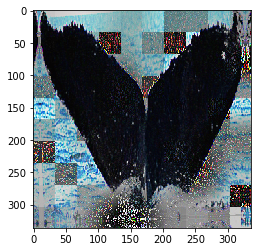

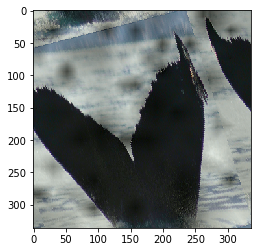

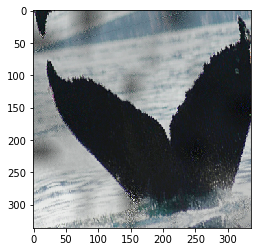

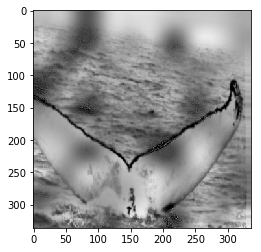

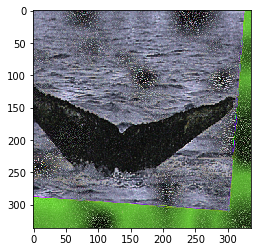

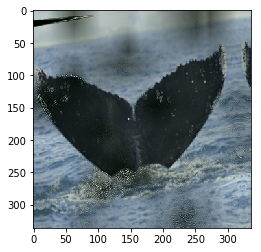

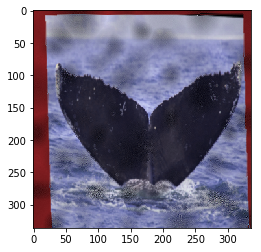

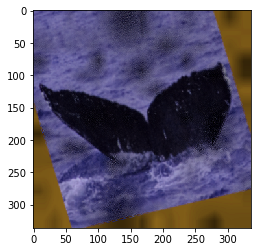

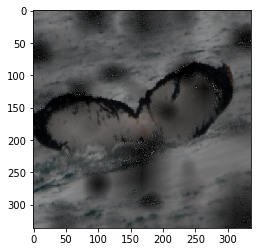

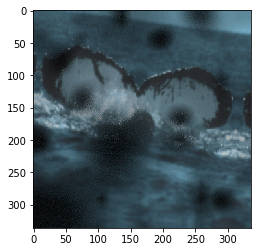

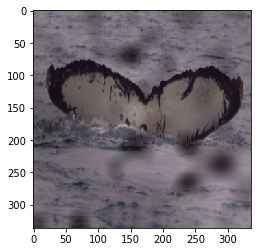

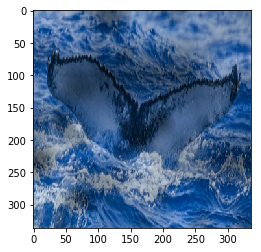

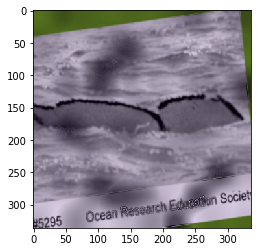

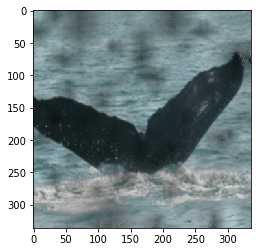

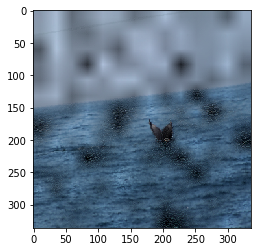

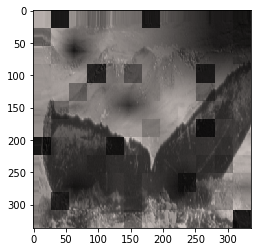

In [10]:
x, y = gen.next()
print(y)

for sample in x[0]:
    plt.imshow(sample)
    plt.show()


In [11]:
model.fit_generator(
            generator=gen,
            validation_data =val_gen,
            validation_steps = len(val)/batch_size,
            steps_per_epoch= len(gen)/batch_size, epochs=500, callbacks = callbacks, verbose =1)

Epoch 1/500
808/807 [==============================] - 257s 318ms/step - loss: 0.9293 - hardest_positive_dist: 0.7656 - hardest_negative_dist: 0.6286 - mean_positive_dist: 0.6743 - mean_negative_dist: 0.7788 - num_neg_pairs: 201.8094 - num_pos_pairs: 38.1906 - val_loss: 0.6850 - val_hardest_positive_dist: 0.7958 - val_hardest_negative_dist: 0.6392 - val_mean_positive_dist: 0.4519 - val_mean_negative_dist: 0.9836 - val_num_neg_pairs: 212.9474 - val_num_pos_pairs: 27.0526
Epoch 2/500
808/807 [==============================] - 264s 326ms/step - loss: 0.7250 - hardest_positive_dist: 1.0516 - hardest_negative_dist: 0.8014 - mean_positive_dist: 0.8552 - mean_negative_dist: 1.1405 - num_neg_pairs: 200.5421 - num_pos_pairs: 39.4579 - val_loss: 0.5098 - val_hardest_positive_dist: 0.8525 - val_hardest_negative_dist: 0.6743 - val_mean_positive_dist: 0.4453 - val_mean_negative_dist: 1.1552 - val_num_neg_pairs: 215.4737 - val_num_pos_pairs: 24.5263
Epoch 3/500
 80/807 [=>...........................

KeyboardInterrupt: 

In [ ]:
model.save('test.h5')